# Wasserstein-based clustering

In [8]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from wkmeans import WKMeans
from MAslope import ma_slope

In [9]:
# Data
df = pd.read_parquet("btc_binance_1d.parquet")
df.head()

Open     High      Low    Close       Volume
Date                                                       
2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377
2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264
2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763
2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022
2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060

In [10]:
# Data
df_features = pd.read_parquet("btc_features.parquet")
df_features.head()

Returns  feature_1  feature_2  feature_3  feature_4
Date                                                            
2017-09-16  0.004032  -1.073904  -1.195123  -0.977491  -0.757684
2017-09-17 -0.004035  -0.911085  -1.097203  -0.930232  -0.737324
2017-09-18  0.086679   1.495757   0.169982  -0.099188  -0.168323
2017-09-19 -0.031461   0.311813  -0.270929  -0.370303  -0.353649
2017-09-20 -0.002571   0.168780  -0.269161  -0.360412  -0.347754

In [ ]:
# The number of clusters
k = 2

# Define dataset
dataset = df_features.values

# Run K-means
kmeans=KMeans(n_clusters=k)
kmeans.fit(dataset)

# Run WK-mean
wkmeans = WKMeans(k=k)
wkmeans.fit(dataset)

# Predict cluster assignments
df_features['cluster'] = kmeans.predict(dataset).tolist()
df_features['wk'] = wkmeans.predict(dataset)

In [12]:
df['cluster'] = df_features['cluster']
df['wk'] = df_features['wk']
df.dropna(inplace=True)

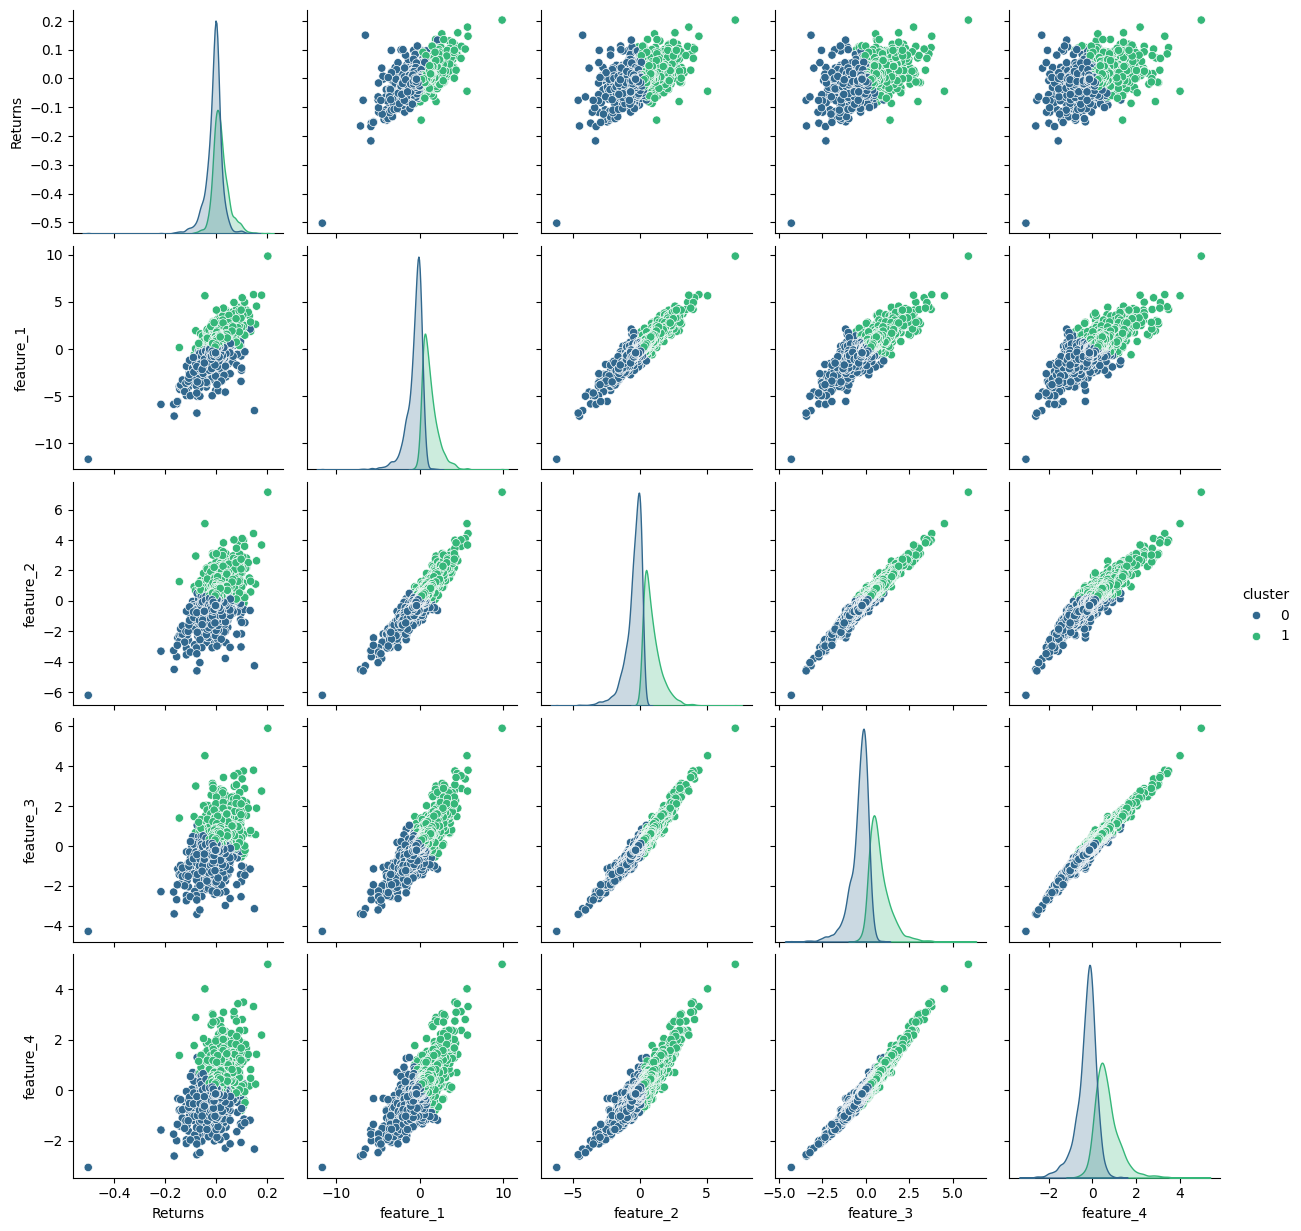

In [13]:
# Plot K-means
df_plot = df_features.drop(columns='wk')
sns.pairplot(df_plot, hue='cluster', palette='viridis', diag_kind='kde')
plt.show();

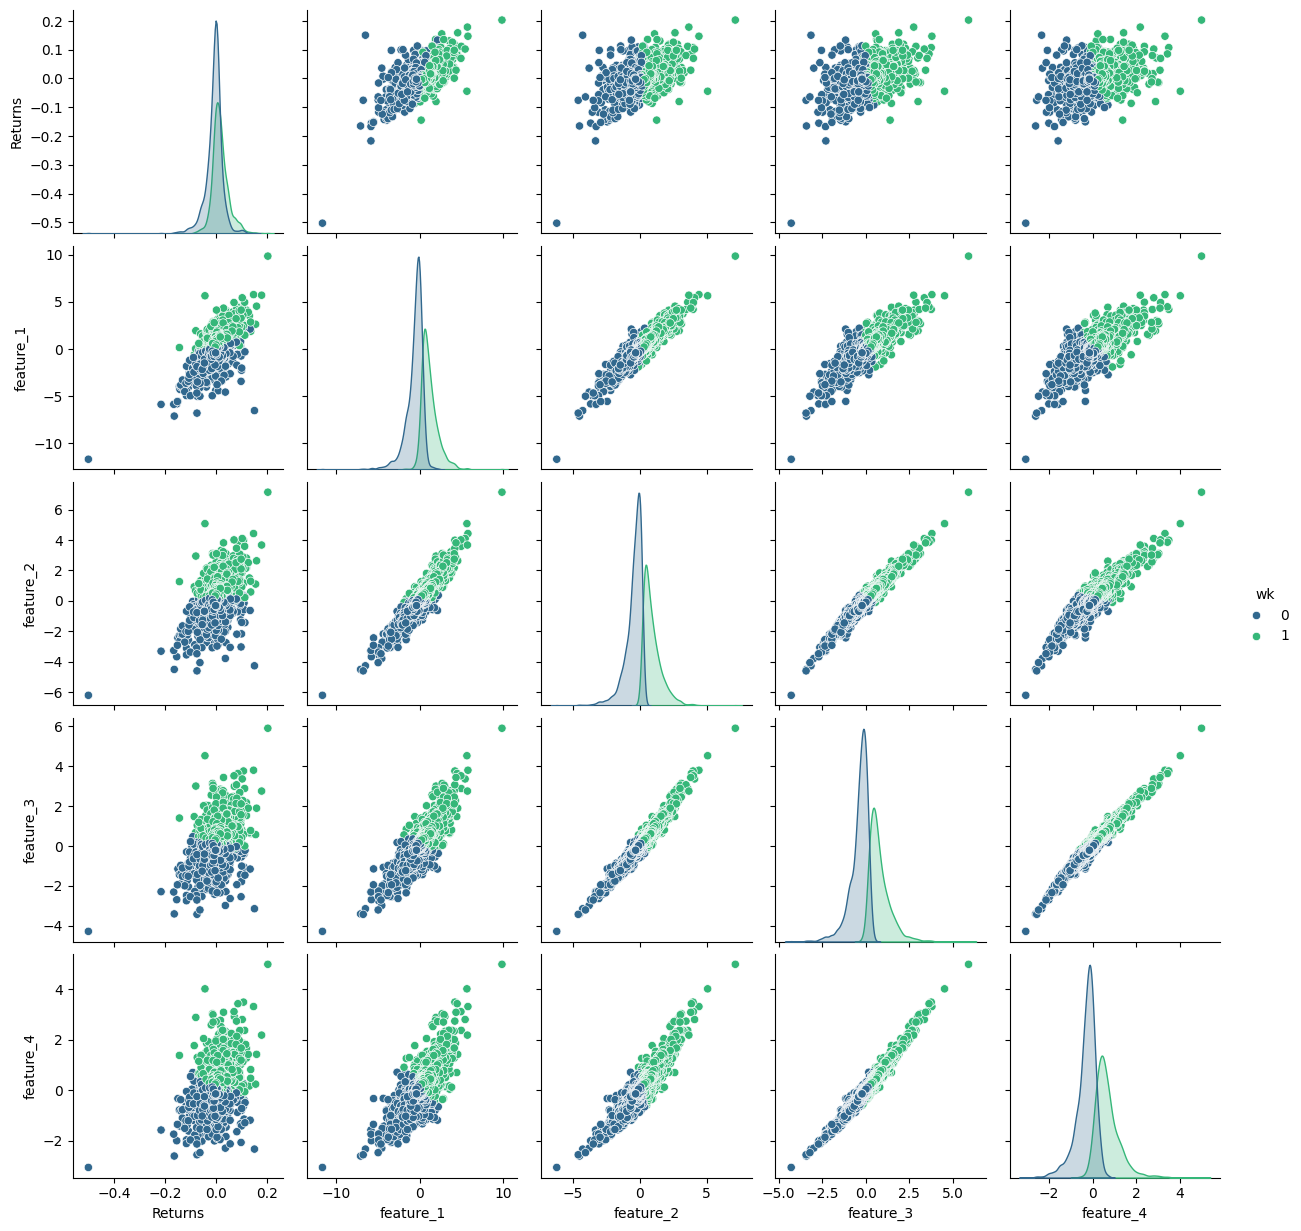

In [14]:
# Plot WK-means
df_plot = df_features.drop(columns='cluster')
sns.pairplot(df_plot, hue='wk', palette='viridis', diag_kind='kde')
plt.show();

In [29]:
# Plot price by K-means
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.7, 0.3],
    subplot_titles=("Price by Cluster", "Assigned Cluster")
)

fig.add_trace(go.Scatter(
    x=df.index, y=close_neutral,
    mode='lines',
    line=dict(color='gray', width=1),
    name='Neutral',
    hoverinfo='skip'
), row=1, col=1)

for c, series in close_cluster.items():
    fig.add_trace(go.Scatter(
        x=df.index, y=series,
        mode='lines',
        line=dict(color=colors[c], width=2.5),
        name=f"Cluster {c}",
        connectgaps=False
    ), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['cluster'],
    mode='lines',
    line=dict(color='cyan', width=1),
    name='Cluster'
), row=2, col=1)

fig.update_layout(
    template='plotly_dark',
    height=700,
    title_text="Market Regime Detector (K-means)",
    hovermode="x unified",
    dragmode='zoom',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_xaxes(rangeslider_visible=False)

fig.show();

In [30]:
# Plot price by WK-means
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['wk'] == c) | (df['wk'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.7, 0.3],
    subplot_titles=("Price by Cluster", "Assigned Cluster")
)

fig.add_trace(go.Scatter(
    x=df.index, y=close_neutral,
    mode='lines',
    line=dict(color='gray', width=1),
    name='Neutral',
    hoverinfo='skip'
), row=1, col=1)

for c, series in close_cluster.items():
    fig.add_trace(go.Scatter(
        x=df.index, y=series,
        mode='lines',
        line=dict(color=colors[c], width=2.5),
        name=f"Cluster {c}",
        connectgaps=False
    ), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['cluster'],
    mode='lines',
    line=dict(color='cyan', width=1),
    name='Cluster'
), row=2, col=1)

fig.update_layout(
    template='plotly_dark',
    height=700,
    title_text="Market Regime Detector (WK-means)",
    hovermode="x unified",
    dragmode='zoom',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_xaxes(rangeslider_visible=False)

fig.show();

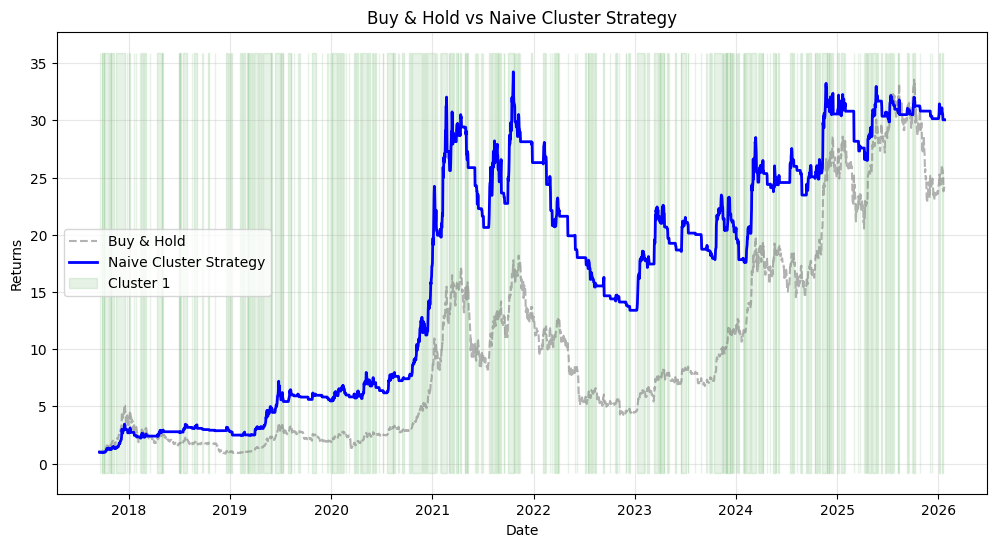

Total Returns Buy & Hold: 2305.63%
Total Returns Naive Cluster Strategy: 2904.40%


In [58]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

df['Signal'] = df['cluster'].shift(1).fillna(0)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()


plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.6, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster']==1), 
                 color='green', alpha=0.1, label='Cluster 1')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show();

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

## Test

In [15]:
split_index = int(len(df) * 0.60)

train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

train_features = df_features.iloc[:split_index]
train_features = df_features.iloc[split_index:]

print(f"Training data: {len(train_data)} candles ({train_data.index[0].date()} - {train_data.index[-1].date()})")
print(f"Test data: {len(test_data)} candles ({test_data.index[0].date()} - {test_data.index[-1].date()})")

Training data: 1831 candles (2017-09-16 - 2022-09-20)
Test data: 1222 candles (2022-09-21 - 2026-01-24)


In [16]:
# Define dataset
dataset = train_features.values

# Run WK-mean
wkmeans = WKMeans(k=k)
wkmeans.fit(dataset)

# Predict cluster assignments
train_features['wk'] = wkmeans.predict(dataset)

In [17]:
train_data['cluster'] = train_features['wk']
train_data.dropna(inplace=True)

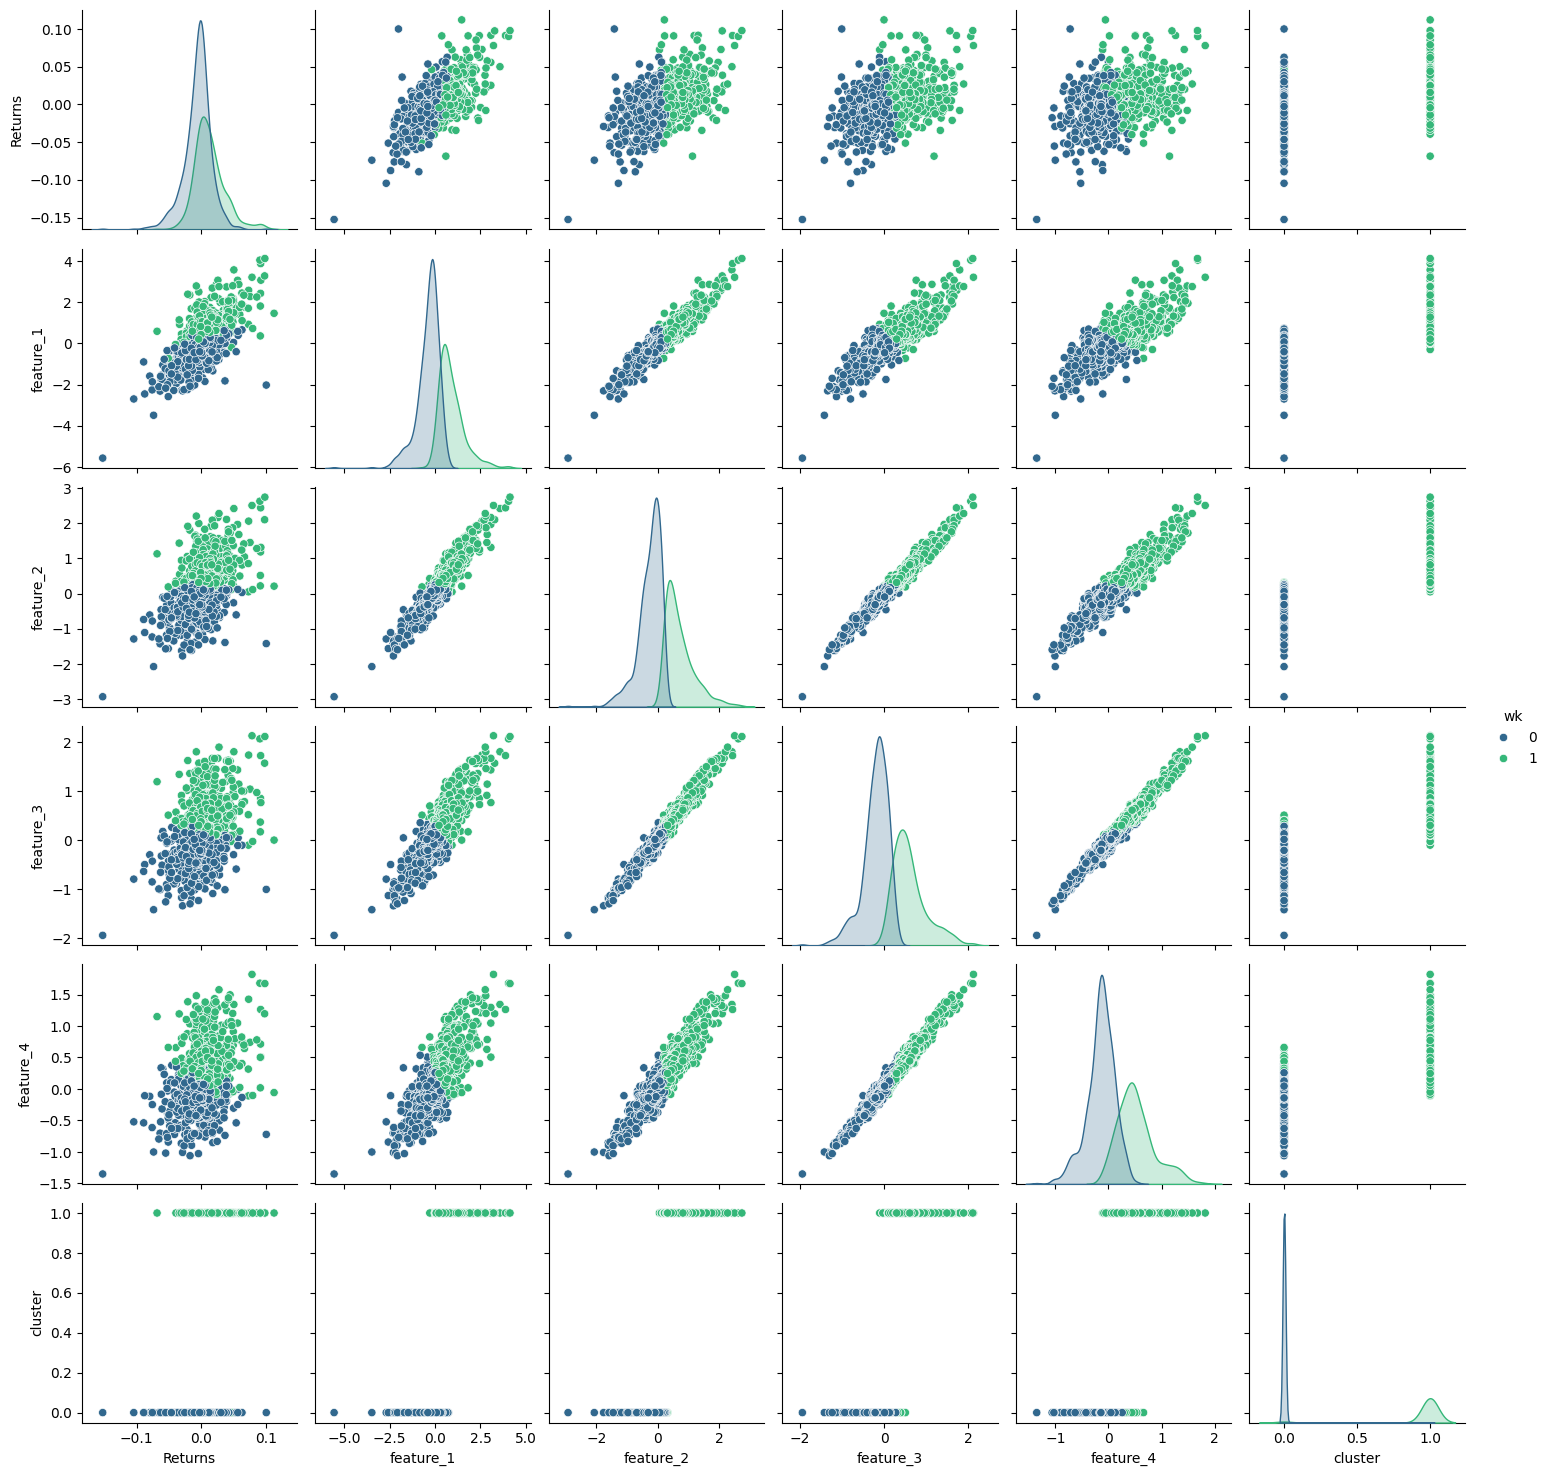

In [18]:
# Plot WK-means
sns.pairplot(train_features, hue='wk', palette='viridis', diag_kind='kde')
plt.show();

In [ ]:
close_neutral = train_data['Close']

colors = {0.0: "red", 1.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (train_data['cluster'] == c) | (train_data['cluster'].shift(-1) == c)
    series = train_data['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.7, 0.3],
    subplot_titles=("Price by Cluster", "Assigned Cluster")
)

fig.add_trace(go.Scatter(
    x=train_data.index, y=close_neutral,
    mode='lines',
    line=dict(color='gray', width=1),
    name='Neutral',
    hoverinfo='skip'
), row=1, col=1)

for c, series in close_cluster.items():
    fig.add_trace(go.Scatter(
        x=train_data.index, y=series,
        mode='lines',
        line=dict(color=colors[c], width=2.5),
        name=f"Cluster {c}",
        connectgaps=False
    ), row=1, col=1)

fig.add_trace(go.Scatter(
    x=train_data.index, y=train_data['cluster'],
    mode='lines',
    line=dict(color='cyan', width=1),
    name='Cluster'
), row=2, col=1)

fig.update_layout(
    template='plotly_dark',
    height=700,
    title_text="Market Regime Detector",
    hovermode="x unified",
    dragmode='zoom',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_xaxes(rangeslider_visible=False)

fig.show();

In [38]:
# Features computation
test_features = pd.DataFrame(index=test_data.index)
test_features = test_data[['Returns', 'slope_7','slope_14','slope_21','slope_30']]
test_features.dropna(inplace=True)

In [39]:
# Define dataset
dataset = test_features.values

# Predict cluster assignments
test_features['wk'] = wkmeans.predict(dataset)

In [41]:
test_data['cluster'] = test_features['wk']
train_data.dropna(inplace=True)

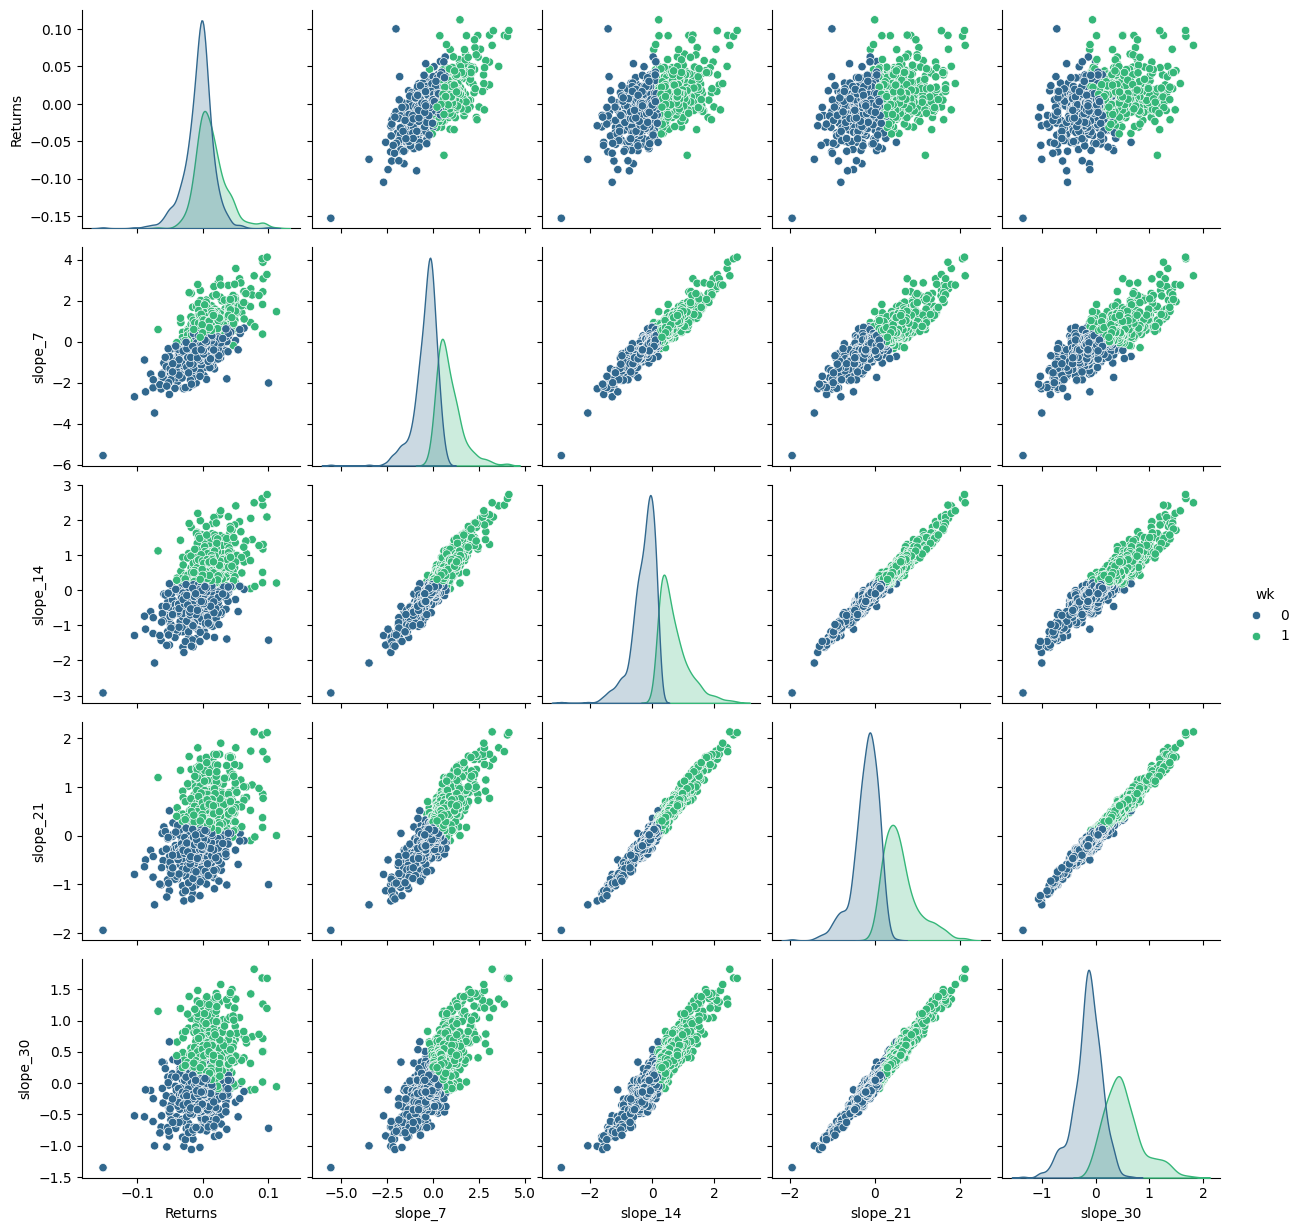

In [40]:
# Plot WK-means
sns.pairplot(test_features, hue='wk', palette='viridis', diag_kind='kde')
plt.show();

In [42]:
close_neutral = test_data['Close']

colors = {0.0: "red", 1.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (test_data['cluster'] == c) | (test_data['cluster'].shift(-1) == c)
    series = test_data['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.7, 0.3],
    subplot_titles=("Price by Cluster", "Assigned Cluster")
)

fig.add_trace(go.Scatter(
    x=test_data.index, y=close_neutral,
    mode='lines',
    line=dict(color='gray', width=1),
    name='Neutral',
    hoverinfo='skip'
), row=1, col=1)

for c, series in close_cluster.items():
    fig.add_trace(go.Scatter(
        x=test_data.index, y=series,
        mode='lines',
        line=dict(color=colors[c], width=2.5),
        name=f"Cluster {c}",
        connectgaps=False
    ), row=1, col=1)

fig.add_trace(go.Scatter(
    x=test_data.index, y=test_data['cluster'],
    mode='lines',
    line=dict(color='cyan', width=1),
    name='Cluster'
), row=2, col=1)

fig.update_layout(
    template='plotly_dark',
    height=700,
    title_text="Market Regime Detector",
    hovermode="x unified",
    dragmode='zoom',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_xaxes(rangeslider_visible=False)

fig.show();

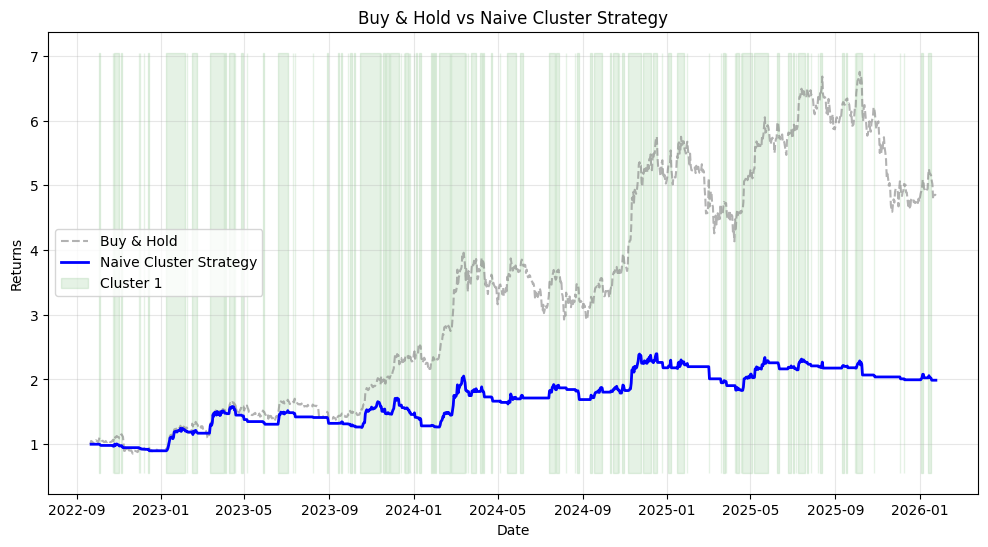

Total Returns Buy & Hold: 384.08%
Total Returns Naive Cluster Strategy: 98.89%


In [48]:
df = test_data

df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

df['Signal'] = df['cluster'].shift(1).fillna(0)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()


plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.6, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster']==1), 
                 color='green', alpha=0.1, label='Cluster 1')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show();

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")